In [ ]:
import pandas as pd
import numpy as np
import kagglehub
import os
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

print("Libraries imported successfully")

Libraries imported successfully


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Load the dataset from a public URL
df = pd.read_csv("/content/drive/MyDrive/ACDT-Sem2/project1/results_nominal (1).csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Libraries imported successfully
entropy-score -- Slope (β1): 4.7498
Intercept (β0): 5.1340
R-squared: 0.7535
p-value (slope): 2.805e-15
Std Err (slope): 0.4050


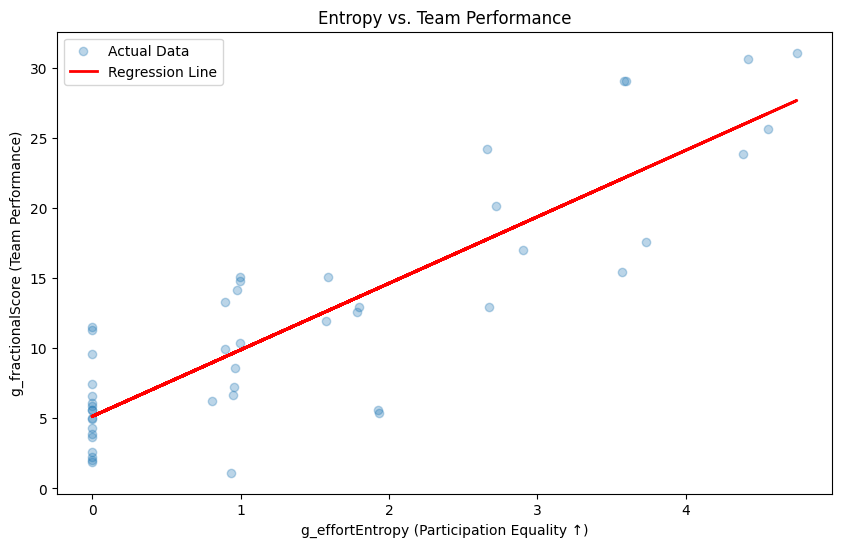

In [ ]:
import pandas as pd
import numpy as np
import kagglehub
import os
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

print("Libraries imported successfully")


#effort entropy per group(high = effort fairly distributed / low = effrort uneqaully distributed)
team_entropy = df.groupby('instanceId')['g_effortEntropy'].first().reset_index()
team_entropy.columns = ['instanceId', 'effort_entropy']
#team score
team_score = df.groupby('instanceId')['g_fractionalScore'].mean().reset_index()
team_score.columns = ['instanceId', 'team_score']

#Make new table
merged = pd.merge(team_score, team_entropy, on='instanceId', how='left')

# eliminate axis
merged = merged.dropna(subset=['effort_entropy', 'team_score'])

#Define each axis
X_axis = merged['effort_entropy']
Y_axis = merged['team_score']

#Regression
slope_s, intercept_s, r_val_s, p_val_s, std_err_s = stats.linregress(X_axis, Y_axis)

print(f"entropy-score -- Slope (β1): {slope_s:.4f}")
print(f"Intercept (β0): {intercept_s:.4f}")
print(f"R-squared: {r_val_s**2:.4f}")
print(f"p-value (slope): {p_val_s:.3e}")
print(f"Std Err (slope): {std_err_s:.4f}")

#Visualization
plt.figure(figsize=(10, 6))
plt.scatter(X_axis, Y_axis, alpha=0.3, label='Actual Data')
plt.plot(X_axis, slope_s * X_axis + intercept_s, color='red', linewidth=2, label='Regression Line')
plt.title('Entropy vs. Team Performance')
plt.xlabel('g_effortEntropy (Participation Equality ↑)')
plt.ylabel('g_fractionalScore (Team Performance)')
plt.legend()
plt.show()

In [ ]:
# === 0) Import & Basic Setup ===
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
from scipy import stats
import statsmodels.api as sm

# df is assumed to be already loaded
# df = pd.read_csv("...results_nominal (1).csv")

# --- Group Level Frame (Mandatory) ---
grouped_df = df.groupby('instanceId').first().reset_index()

# --- Analysis Parameters ---
ALPHA_NEW = 0.10             # p-value cut (Relaxed)
R_SQUARED_CUTOFF = 0.40      # R² cut (Strict)
X_var = 'g_effortEntropy'    # Independent variable
Y_var = 'g_fractionalScore'  # Dependent variable

# --- Exclude outcome-like variables (unsuitable as mediators) ---
exclude_outcome_like = {'g_f1','g_precision','g_recall','g_binaryScore','g_fractionalScore'}

# --- Select all 'g_' variables that are numeric as M candidates (excluding X, Y, and outcome-like) ---
all_group_vars = [c for c in grouped_df.columns if c.startswith('g_')]
M_candidates_final = [
    v for v in all_group_vars
    if v not in {X_var, Y_var} | exclude_outcome_like
    and is_numeric_dtype(grouped_df[v])
]

# === 1) Simple Regression Scan for X→M and M→Y (Standard OLS, collect p & R²) ===
regression_results = []
for var in M_candidates_final:
    # (A) X -> M
    sub_xm = grouped_df[[X_var, var]].dropna()
    if len(sub_xm) > 5:
        X = sm.add_constant(sub_xm[X_var])
        Y = sub_xm[var]
        m_xm = sm.OLS(Y, X).fit()
        beta = m_xm.params[X_var]
        regression_results.append({
            'M_Variable': var,
            'Path': 'X_to_M',
            'R_squared': float(m_xm.rsquared),
            'p_value': float(m_xm.pvalues[X_var]),
            'Beta_Sign': '+' if beta > 0 else ('-' if beta < 0 else '0')
        })

    # (B) M -> Y
    sub_my = grouped_df[[var, Y_var]].dropna()
    if len(sub_my) > 5:
        X2 = sm.add_constant(sub_my[var])
        Y2 = sub_my[Y_var]
        m_my = sm.OLS(Y2, X2).fit()
        beta2 = m_my.params[var]
        regression_results.append({
            'M_Variable': var,
            'Path': 'M_to_Y',
            'R_squared': float(m_my.rsquared),
            'p_value': float(m_my.pvalues[var]),
            'Beta_Sign': '+' if beta2 > 0 else ('-' if beta2 < 0 else '0')
        })

reg_df = pd.DataFrame(regression_results)

# === 2) Filtering by Thresholds (p < ALPHA_NEW & R² >= R_SQUARED_CUTOFF) ===
x_m_filter = reg_df.query(
    f"Path == 'X_to_M' and p_value < {ALPHA_NEW} and R_squared >= {R_SQUARED_CUTOFF}"
)['M_Variable']

m_y_filter = reg_df.query(
    f"Path == 'M_to_Y' and p_value < {ALPHA_NEW} and R_squared >= {R_SQUARED_CUTOFF}"
)['M_Variable']

final_mediators = sorted(list(set(x_m_filter) & set(m_y_filter)))

# === 3) Create Table (including signs) ===
df_xm = reg_df.query("Path == 'X_to_M'").set_index('M_Variable')[['R_squared','p_value','Beta_Sign']]
df_xm.columns = ['X_to_M_R2','X_to_M_P','X_to_M_Sign']

df_my = reg_df.query("Path == 'M_to_Y'").set_index('M_Variable')[['R_squared','p_value','Beta_Sign']]
df_my.columns = ['M_to_Y_R2','M_to_Y_P','M_to_Y_Sign']

merged_table = df_xm.join(df_my, how='inner')  # Variables present in both paths
final_table = merged_table.loc[final_mediators].reset_index()

# Formatting for display (display as string, keep internal as float)
fmt = lambda x: f"{x:.4f}"
if not final_table.empty:
    final_table_display = final_table.copy()
    final_table_display['X_to_M_R2'] = final_table_display['X_to_M_R2'].map(fmt)
    final_table_display['M_to_Y_R2'] = final_table_display['M_to_Y_R2'].map(fmt)
    final_table_display['X_to_M_P']  = final_table_display['X_to_M_P'].map('{:.8f}'.format)
    final_table_display['M_to_Y_P']  = final_table_display['M_to_Y_P'].map('{:.8f}'.format)
else:
    final_table_display = final_table

# === 4) Output Results ===
print("="*100)
print(f"PASS: Final Mediator Candidates (p < {ALPHA_NEW} & R² ≥ {R_SQUARED_CUTOFF})")
print("="*100)
print(f"Number of selected mediators: {len(final_mediators)}\n")
print(final_table_display.to_string(index=False))


PASS: Final Mediator Candidates (p < 0.1 & R² ≥ 0.4)
Number of selected mediators: 9

          M_Variable X_to_M_R2   X_to_M_P X_to_M_Sign M_to_Y_R2   M_to_Y_P M_to_Y_Sign
        g_chatWeight    0.6735 0.00000000           +    0.5363 0.00000000           +
    g_classifyWeight    0.8315 0.00000000           +    0.9393 0.00000000           +
g_eventCollaboration    0.6593 0.00000000           +    0.4127 0.00000113           +
      g_filterWeight    0.7842 0.00000000           +    0.5958 0.00000000           +
        g_fracFemale    0.5653 0.00000070           -    0.4741 0.00001323           -
       g_nominalSize    0.8139 0.00000000           +    0.6757 0.00000000           +
        g_personTime    0.8072 0.00000000           +    0.6816 0.00000000           +
       g_totalEffort    0.8068 0.00000000           +    0.6986 0.00000000           +
      g_verifyWeight    0.6520 0.00000000           +    0.5794 0.00000000           +


In [ ]:

# === VIF Pruning: Applied only to the 'final_mediators' from above ===
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(df):
    X = sm.add_constant(df)
    out = []
    # Note: the variance_inflation_factor function expects the intercept at index 0,
    # so we iterate from index 1 for the actual variables.
    for i, col in enumerate(df.columns):
        out.append({'Variable': col,
                    'VIF': variance_inflation_factor(X.values, i+1)})
    return pd.DataFrame(out).sort_values('VIF', ascending=False)

def prune_by_vif(dataframe, vars_list, threshold=10.0):
    keep = vars_list[:]
    it = 0
    while len(keep) >= 2:
        sub = dataframe[keep].dropna()
        if sub.shape[1] < 2 or sub.shape[0] < 5:
            break
        vif_df = compute_vif(sub)
        worst_row = vif_df.iloc[0]
        it += 1
        print(f"\nRETRY Iter {it}: max VIF={worst_row['VIF']:.2f} ({worst_row['Variable']})")
        if worst_row['VIF'] > threshold:
            print(f"FAIL Removing '{worst_row['Variable']}'")
            keep.remove(worst_row['Variable'])
        else:
            print("PASS All remaining variables ≤ threshold.")
            break
    final_vif = compute_vif(dataframe[keep].dropna()) if len(keep) >= 2 else pd.DataFrame()
    return keep, final_vif

if len(final_mediators) < 2:
    print("\n(VIF) Skipping VIF as there are fewer than 2 candidate variables:", final_mediators)
    final_vars_vif = final_mediators
    final_vif_table = pd.DataFrame()
else:
    sub_for_vif = grouped_df[final_mediators].copy()
    final_vars_vif, final_vif_table = prune_by_vif(sub_for_vif, final_mediators, threshold=10.0)

print("\n=== PASS Core Candidates Remaining After VIF Pruning ===")
print(final_vars_vif)

if not final_vif_table.empty:
    print("\n=== Final VIF Table ===")
    print(final_vif_table.to_string(index=False, float_format=lambda x: f"{x:,.2f}"))



RETRY Iter 1: max VIF=2071.70 (g_totalEffort)
FAIL Removing 'g_totalEffort'

RETRY Iter 2: max VIF=389.21 (g_personTime)
FAIL Removing 'g_personTime'

RETRY Iter 3: max VIF=34.35 (g_nominalSize)
FAIL Removing 'g_nominalSize'

RETRY Iter 4: max VIF=17.16 (g_verifyWeight)
FAIL Removing 'g_verifyWeight'

RETRY Iter 5: max VIF=9.95 (g_filterWeight)
PASS All remaining variables ≤ threshold.

=== PASS Core Candidates Remaining After VIF Pruning ===
['g_chatWeight', 'g_classifyWeight', 'g_eventCollaboration', 'g_filterWeight', 'g_fracFemale']

=== Final VIF Table ===
            Variable  VIF
      g_filterWeight 9.95
        g_chatWeight 6.46
    g_classifyWeight 5.38
g_eventCollaboration 3.75
        g_fracFemale 2.00


In [ ]:
# --- Single mediation for each mediator (short) ---
import numpy as np, pandas as pd, statsmodels.api as sm
from scipy.stats import norm

X, Y = 'g_effortEntropy', 'g_fractionalScore'
MEDIATORS = ['g_filterWeight','g_chatWeight','g_classifyWeight','g_eventCollaboration','g_fracFemale']

def z(df, cols):
    out = df.copy()
    for c in cols:
        s = out[c]; sd = s.std(ddof=0)
        out[c+'_z'] = (s - s.mean()) / (sd if sd!=0 else 1.0)
    return out

rows = []
for M in MEDIATORS:
    d = grouped_df[[X,Y,M]].dropna()
    d = z(d,[X,Y,M])
    Xz, Yz, Mz = X+'_z', Y+'_z', M+'_z'

    a_mod = sm.OLS.from_formula(f'{Mz} ~ {Xz}', data=d).fit()
    bcp_mod = sm.OLS.from_formula(f'{Yz} ~ {Mz} + {Xz}', data=d).fit()
    c_mod = sm.OLS.from_formula(f'{Yz} ~ {Xz}', data=d).fit()

    a, sa = a_mod.params[Xz], a_mod.bse[Xz]
    b, sb = bcp_mod.params[Mz], bcp_mod.bse[Mz]
    c, c_p = c_mod.params[Xz], c_mod.pvalues[Xz]
    cprime, cprime_p = bcp_mod.params[Xz], bcp_mod.pvalues[Xz]
    indirect = a*b
    sobel_z = indirect/np.sqrt((b**2)*(sa**2) + (a**2)*(sb**2))
    sobel_p = 2*(1-norm.cdf(abs(sobel_z)))

    rows.append({
        'Mediator': M,
        'a': a, 'b': b, 'c': c, "c'": cprime,
        'a*b': indirect, 'Sobel p': sobel_p,
        'N': len(d)
    })

single_tbl = pd.DataFrame(rows)
print(single_tbl.to_string(index=False, float_format=lambda x: f'{x:.4f}'))


            Mediator       a       b      c      c'     a*b  Sobel p  N
      g_filterWeight  0.8856  0.0147 0.8680  0.8550  0.0130   0.9273 47
        g_chatWeight  0.8207  0.0611 0.8680  0.8179  0.0501   0.6407 47
    g_classifyWeight  0.9119  1.0541 0.8680 -0.0932  0.9612   0.0000 47
g_eventCollaboration  0.8119 -0.1831 0.8680  1.0167 -0.1487   0.1486 47
        g_fracFemale -0.7518 -0.0344 0.8959  0.8701  0.0259   0.7834 32


In [ ]:
# --- Multiple mediation (all 5 mediators together) ---
Ms = MEDIATORS
d = grouped_df[[X,Y] + Ms].dropna()
# z-score
for c in [X,Y] + Ms:
    s = d[c]; sd = s.std(ddof=0)
    d[c+'_z'] = (s - s.mean())/(sd if sd!=0 else 1.0)
Xz, Yz = X+'_z', Y+'_z'; Mz = [m+'_z' for m in Ms]

# a_k: Mk ~ X
a = {}
for m in Ms:
    fit = sm.OLS.from_formula(f'{m}_z ~ {Xz}', data=d).fit()
    a[m] = fit.params[Xz]

# b_k, c': Y ~ X + M1+...+M5
rhs = ' + '.join([Xz] + Mz)
fit_multi = sm.OLS.from_formula(f'{Yz} ~ {rhs}', data=d).fit()
b = {m: fit_multi.params.get(m+'_z', np.nan) for m in Ms}
cprime = fit_multi.params[Xz]

multi_tbl = pd.DataFrame({
    'Mediator': Ms,
    'a': [a[m] for m in Ms],
    'b (|X, others)': [b[m] for m in Ms],
    'a*b': [a[m]*b[m] for m in Ms]
})
print(multi_tbl.to_string(index=False, float_format=lambda x: f'{x:.4f}'))
print(f"\nDirect effect c′ (X→Y | all mediators): {cprime:.4f}")


            Mediator       a  b (|X, others)     a*b
      g_filterWeight  0.9104         -0.4174 -0.3800
        g_chatWeight  0.8134          0.1384  0.1126
    g_classifyWeight  0.9317          1.0663  0.9935
g_eventCollaboration  0.7915         -0.0840 -0.0665
        g_fracFemale -0.7518         -0.0378  0.0284

Direct effect c′ (X→Y | all mediators): 0.2079
